# Store Item Sales Prediction

## Çıkarımlar
* Train verisi  4 yıllıktır(17-18-19-20) ve tüm günleri içermektedir.
* Test verisi 1 yıllıktır(21) ve tüm günleri içermektedir.
* Train ve Test verisinde NaN değer yoktur.
* Train verisinde 70128 gözlem, test verisinde 17520 gözlem bulunmaktadır 

In [1]:
# kütüphaneleri import edelim
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# verileri yükleyelim
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
df=pd.concat([train,test],sort=False)

In [4]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663.0
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615.0
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480.0
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710.0
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240.0


In [5]:
test.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


In [6]:
# veriyi genel olarak inceleyelim
def check_df(dataframe):
    print(f"Observations:{dataframe.shape[0]}",end="\n")
    print(f"Variables:{dataframe.shape[1]}",end="\n")
    print(f"NaN Values\n{dataframe.isnull().sum()}",end="\n")
    print(f"Types\n{dataframe.dtypes}",end="\n")
    for col_name in list(dataframe.columns):
        if dataframe[col_name].nunique()>10:
            print(f"{col_name}\n{dataframe[col_name].nunique()}")
        else:
            print(f"{col_name}\n{dataframe[col_name].unique()}")

In [7]:
check_df(train)

Observations:87648
Variables:6
NaN Values
row_id          0
date            0
country         0
store           0
product         0
num_sold    17520
dtype: int64
Types
row_id        int64
date         object
country      object
store        object
product      object
num_sold    float64
dtype: object
row_id
87648
date
1826
country
['Belgium' 'France' 'Germany' 'Italy' 'Poland' 'Spain']
store
['KaggleMart' 'KaggleRama']
product
['Kaggle Advanced Techniques' 'Kaggle Getting Started'
 'Kaggle Recipe Book' 'Kaggle for Kids: One Smart Goose']
num_sold
699


In [8]:
# date değişkenini datetime'e dönüştürelim
train["date"]=pd.to_datetime(train["date"],dayfirst=True)
test["date"]=pd.to_datetime(test["date"],dayfirst=True)
df["date"]=pd.to_datetime(df["date"],dayfirst=True)

In [9]:
# date değişkenini yıl,ay,gün olarak ayıralım
train["year"]=train.date.dt.year
train["month"]=train.date.dt.month
train["day_of_year"]=train.date.dt.dayofyear
train["day_of_week"]=train.date.dt.dayofweek
train["week_of_year"]=train.date.dt.weekofyear
train["is_month_start"]=train.date.dt.is_month_start.astype(int)
train["is_wknd"]=train.date.dt.weekday
train["is_month_end"]=train.date.dt.is_month_end.astype(int)
train["day"]=train.date.dt.day

C:\Users\akdog\AppData\Local\Temp\ipykernel_10716\812043949.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train["week_of_year"]=train.date.dt.weekofyear


In [10]:
train.tail()

,row_id,date,country,store,product,num_sold,year,month,day_of_year,day_of_week,week_of_year,is_month_start,is_wknd,is_month_end,day
17515,87643,2021-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,NaN,2021,12,365,4,52,0,4,1,31
17516,87644,2021-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,NaN,2021,12,365,4,52,0,4,1,31
17517,87645,2021-12-31,Spain,KaggleRama,Kaggle Getting Started,NaN,2021,12,365,4,52,0,4,1,31
17518,87646,2021-12-31,Spain,KaggleRama,Kaggle Recipe Book,NaN,2021,12,365,4,52,0,4,1,31
17519,87647,2021-12-31,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,NaN,2021,12,365,4,52,0,4,1,31


In [11]:
train.date.min()

Timestamp('2017-01-01 00:00:00')

In [12]:
train.date.max()

Timestamp('2021-12-31 00:00:00')

In [13]:
test.date.min()

Timestamp('2021-01-01 00:00:00')

In [14]:
test.date.max()

Timestamp('2021-12-31 00:00:00')

In [15]:
test.date.nunique()

365

In [16]:
# verideki türleri ayrıştıralım
def grab_col(dataframe,cat_threshold=10,car_threshold=20):
    cat_cols=[col for col in dataframe.columns if dataframe[col].dtypes in ["object","category","bool"]]
    num_but_cat=[col for col in dataframe.columns if dataframe[col].dtypes in ["int64","float64"] and dataframe[col].nunique()<=cat_threshold]
    num_cols=[col for col in dataframe.columns if dataframe[col].dtypes in ["int64","float64"] and col not in num_but_cat]
    cat_but_car=[col for col in cat_cols if dataframe[col].nunique()>car_threshold]
    cat_cols=cat_cols+num_but_cat
    cat_cols=[col for col in cat_cols if col not in cat_but_car]
    return cat_cols,num_cols,cat_but_car

In [17]:
cat_cols,num_cols,cat_but_car=grab_col(train)

In [18]:
cat_cols

['country', 'store', 'product', 'year', 'day_of_week', 'is_wknd']

In [19]:
num_cols

['row_id', 'num_sold', 'month', 'day_of_year', 'week_of_year', 'day']

In [20]:
cat_but_car

[]

In [21]:
# date değişkeni datetime türünde, üstteki kategorilerde yer almıyor

In [22]:
train.shape

(87648, 15)

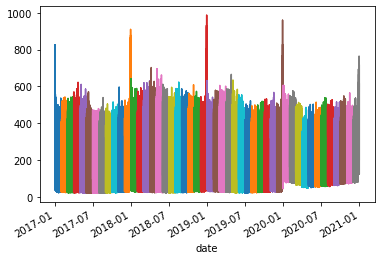

In [23]:
train.set_index("date").resample("m").num_sold.plot()
plt.show()

In [24]:
# kategorik verileri inceleyelim
def sum_cat(dataframe,cat_col):
    print(pd.DataFrame({cat_col:dataframe[cat_col].value_counts(), "Ratio":dataframe[cat_col].value_counts()/len(dataframe[cat_col])}))
    sns.countplot(x=cat_col,hue=cat_col,data=dataframe,saturation=1,linewidth=None)
    plt.xticks(rotation=45)
    plt.show(block=True)

         country     Ratio
Belgium    14608  0.166667
France     14608  0.166667
Germany    14608  0.166667
Italy      14608  0.166667
Poland     14608  0.166667
Spain      14608  0.166667


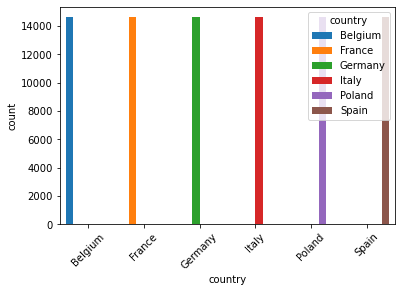

            store  Ratio
KaggleMart  43824    0.5
KaggleRama  43824    0.5


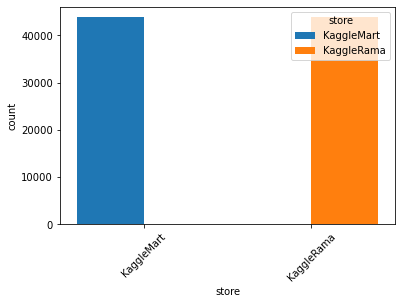

                                  product  Ratio
Kaggle Advanced Techniques          21912   0.25
Kaggle Getting Started              21912   0.25
Kaggle Recipe Book                  21912   0.25
Kaggle for Kids: One Smart Goose    21912   0.25


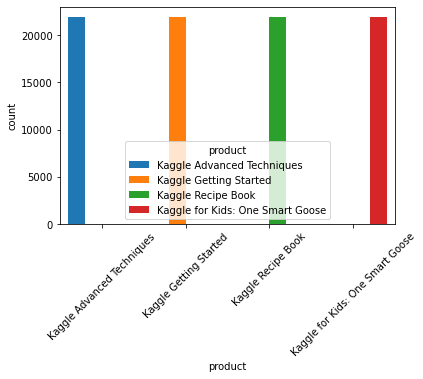

       year     Ratio
2020  17568  0.200438
2017  17520  0.199890
2018  17520  0.199890
2019  17520  0.199890
2021  17520  0.199890


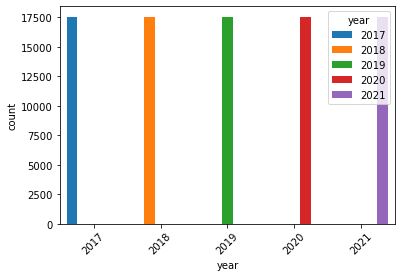

   day_of_week     Ratio
6        12528  0.142935
0        12528  0.142935
1        12528  0.142935
2        12528  0.142935
3        12528  0.142935
4        12528  0.142935
5        12480  0.142388


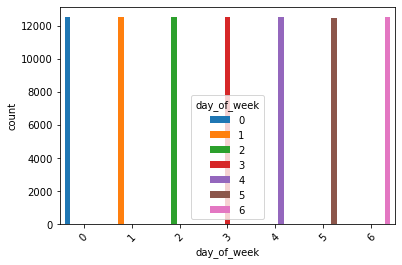

   is_wknd     Ratio
6    12528  0.142935
0    12528  0.142935
1    12528  0.142935
2    12528  0.142935
3    12528  0.142935
4    12528  0.142935
5    12480  0.142388


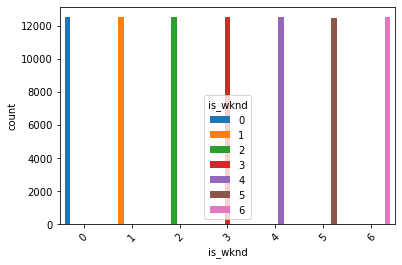

In [25]:
for col_name in cat_cols:
    sum_cat(train,col_name)

In [26]:
# sayısal verileri inceleyelim
def num_summary(dataframe,num_col):
    print(dataframe[num_col].describe(),end="\n")
    dataframe[num_col].hist(bins="auto")
    plt.show(block=True)

count    70128.000000
mean       194.296986
std        126.893874
min         19.000000
25%         95.000000
50%        148.000000
75%        283.000000
max        986.000000
Name: num_sold, dtype: float64


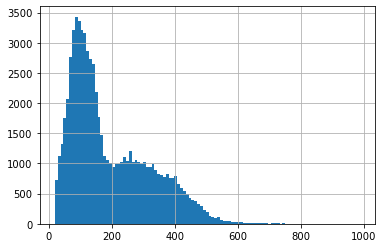

count    87648.000000
mean         6.523549
std          3.448553
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64


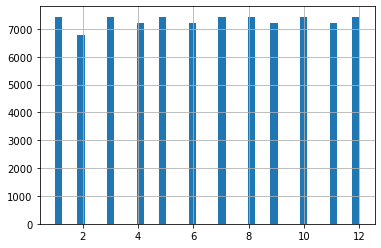

count    87648.000000
mean       183.100219
std        105.424745
min          1.000000
25%         92.000000
50%        183.000000
75%        274.000000
max        366.000000
Name: day_of_year, dtype: float64


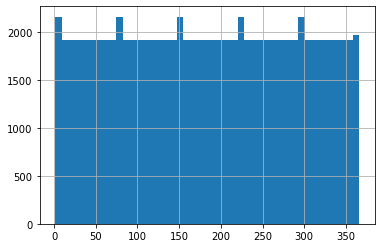

count    87648.000000
mean        26.587623
std         15.061233
min          1.000000
25%         14.000000
50%         27.000000
75%         40.000000
max         53.000000
Name: week_of_year, dtype: float64


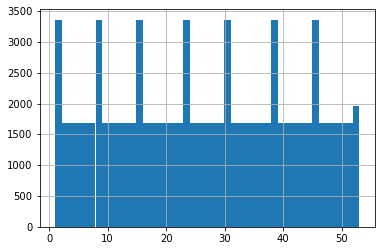

count    87648.000000
mean        15.727820
std          8.799375
min          1.000000
25%          8.000000
50%         16.000000
75%         23.000000
max         31.000000
Name: day, dtype: float64


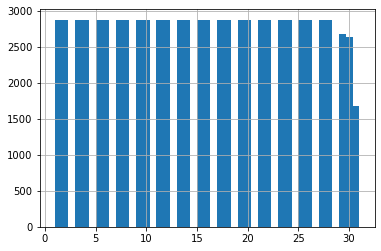

In [27]:
num_cols=[col for col in num_cols if col not in ["row_id"]]
for col_name in num_cols:
    num_summary(train,col_name)

<AxesSubplot:xlabel='date'>

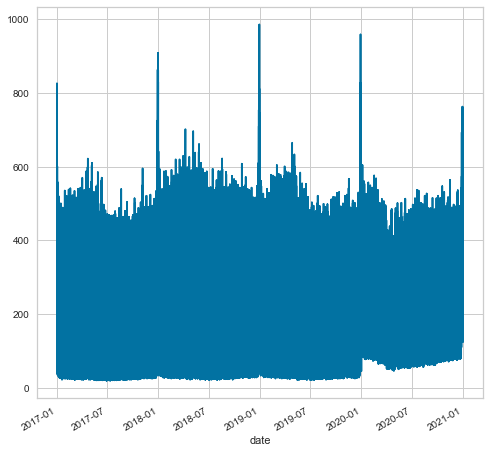

In [442]:
# zamana göre satış sayılarını inceleyelim
# kopyalama işlemi yapalım
new_train=train.copy()
new_train.set_index("date",inplace=True)
new_train.loc[:,"num_sold"].plot(figsize=(8,8))

<AxesSubplot:xlabel='date'>

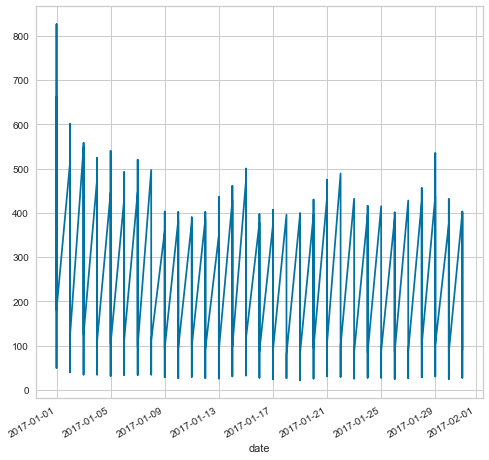

In [443]:
new_train.loc[(new_train.year==2017)  & (new_train.month==1),"num_sold"].plot(figsize=(8,8))

<AxesSubplot:xlabel='date'>

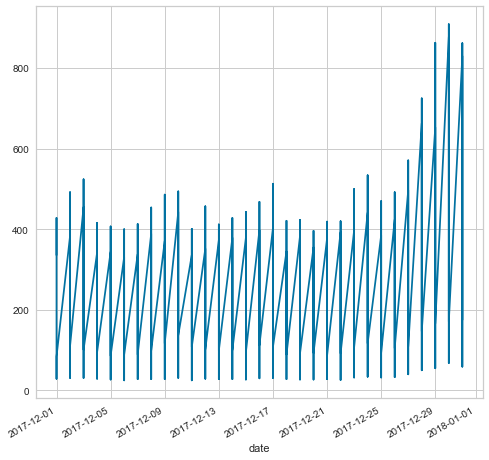

In [444]:
new_train.loc[(new_train.year==2017)  & (new_train.month==12),"num_sold"].plot(figsize=(8,8))

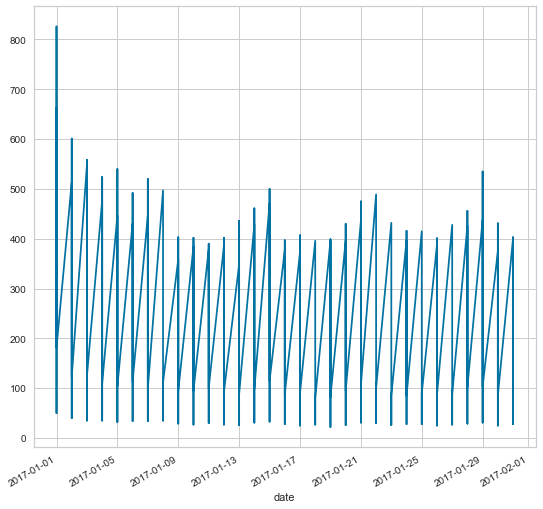

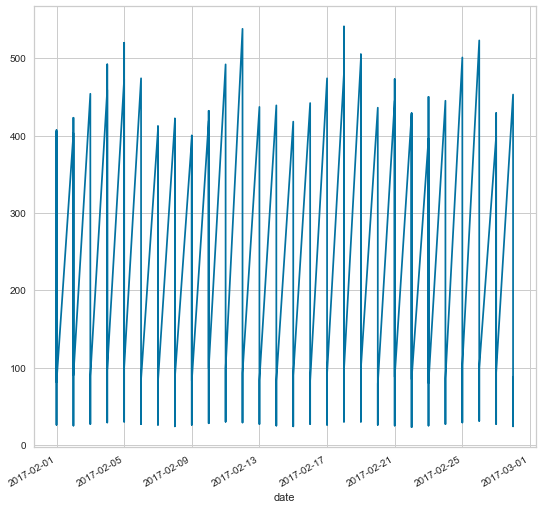

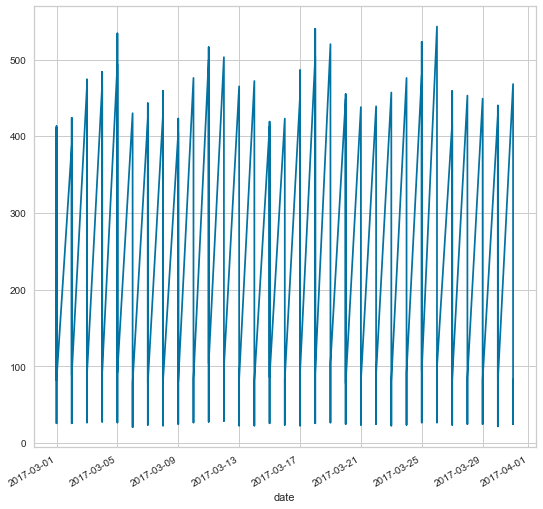

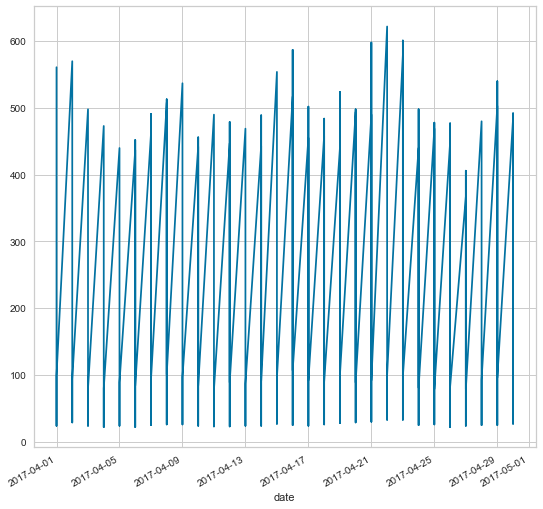

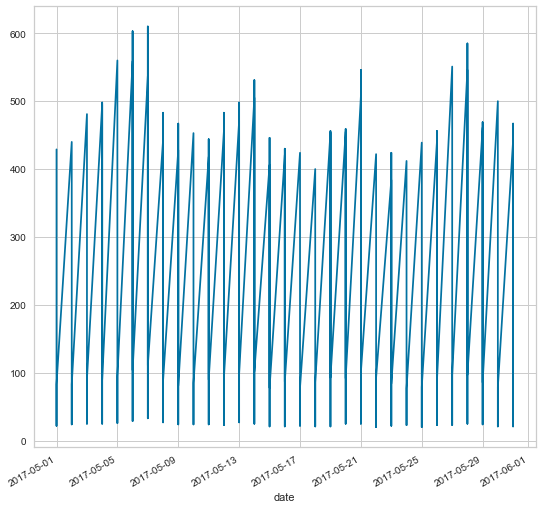

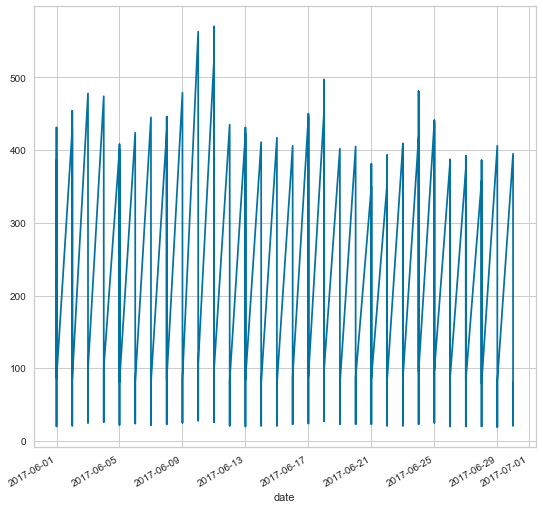

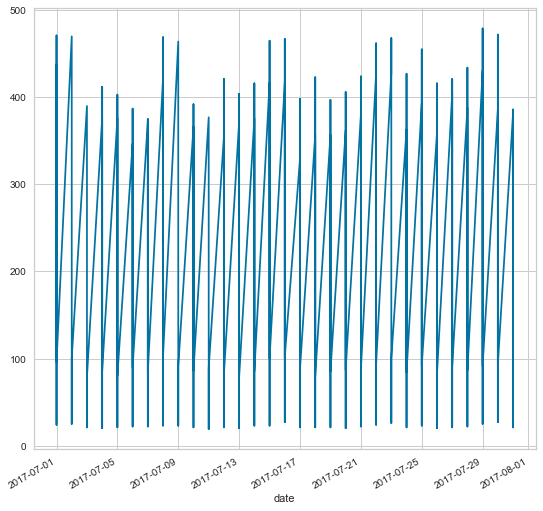

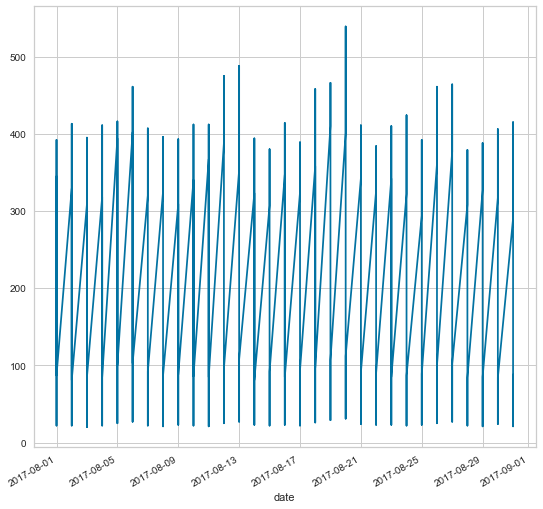

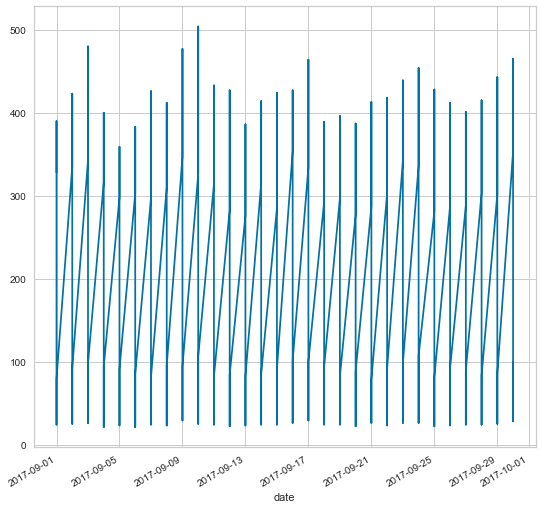

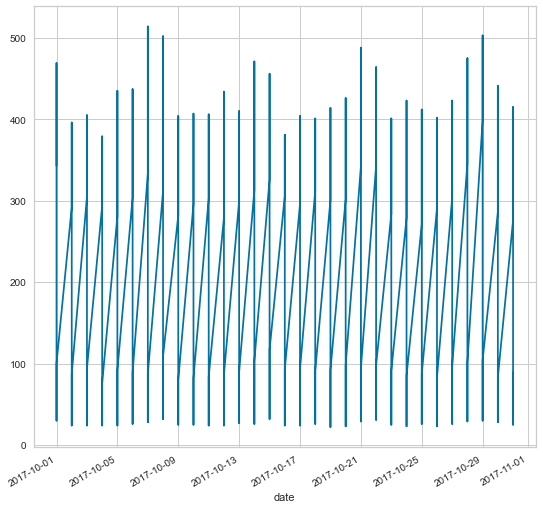

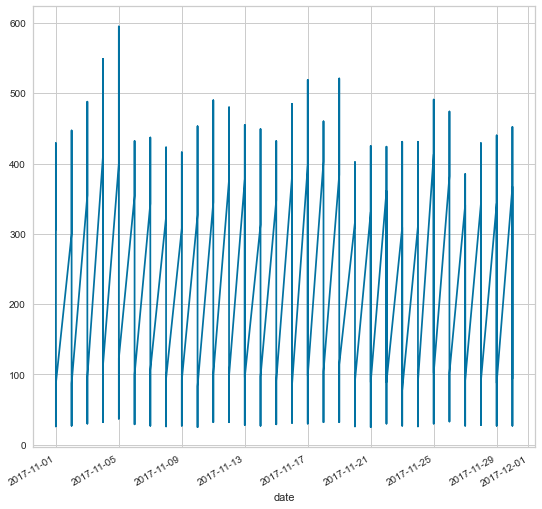

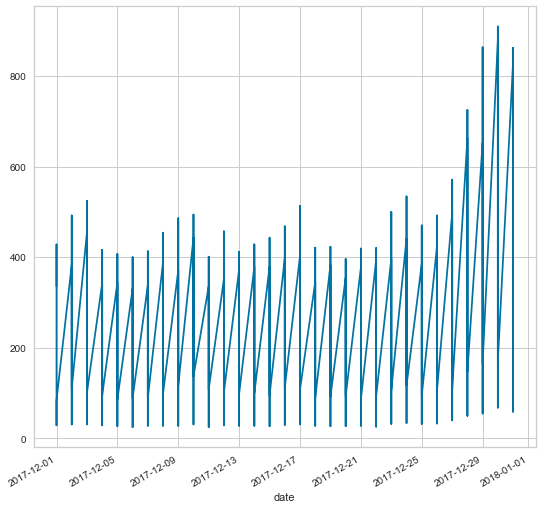

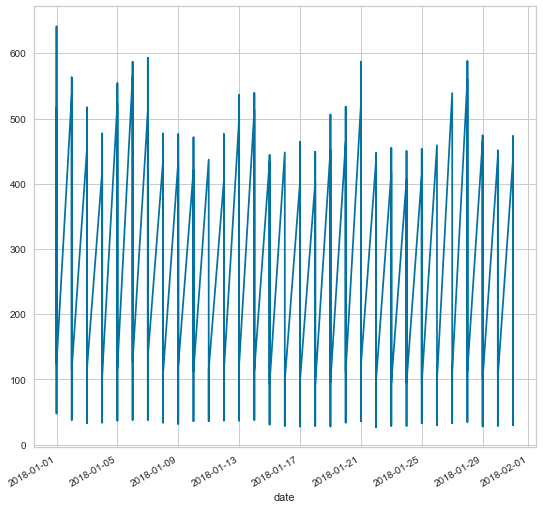

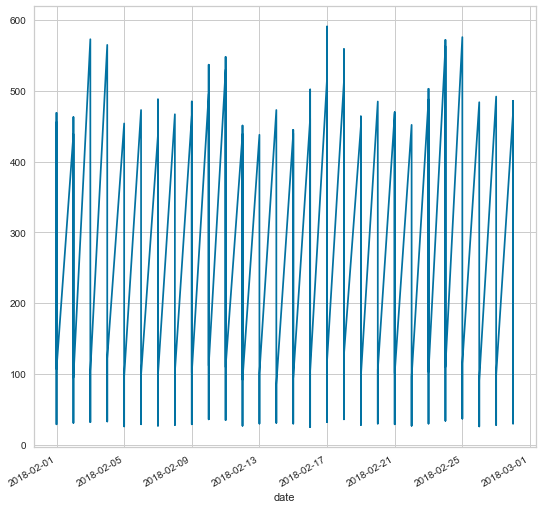

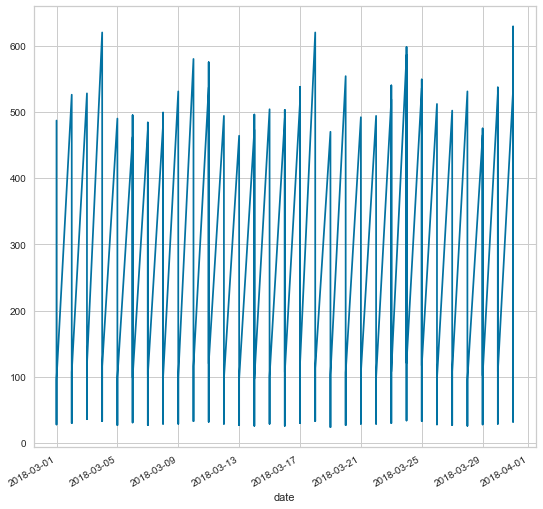

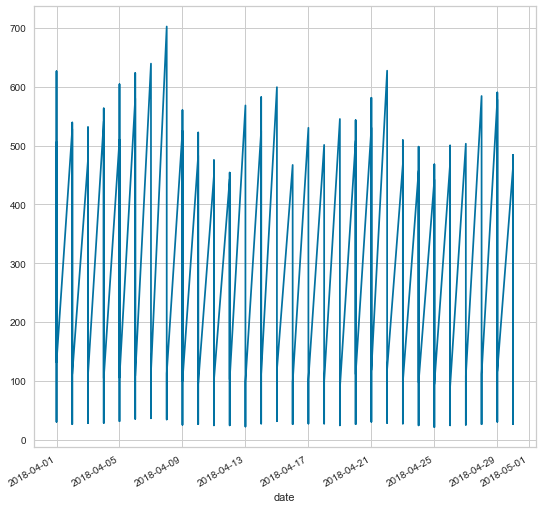

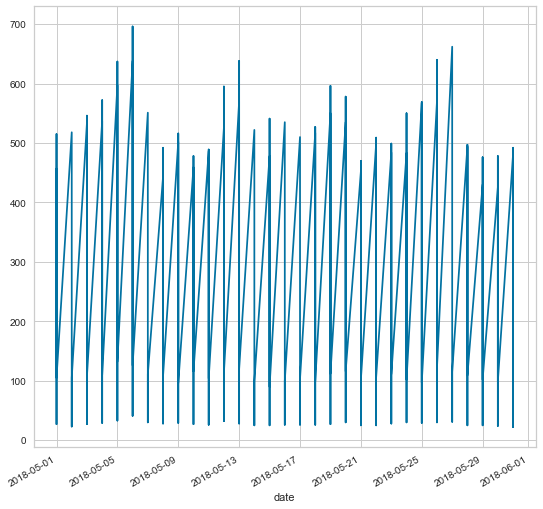

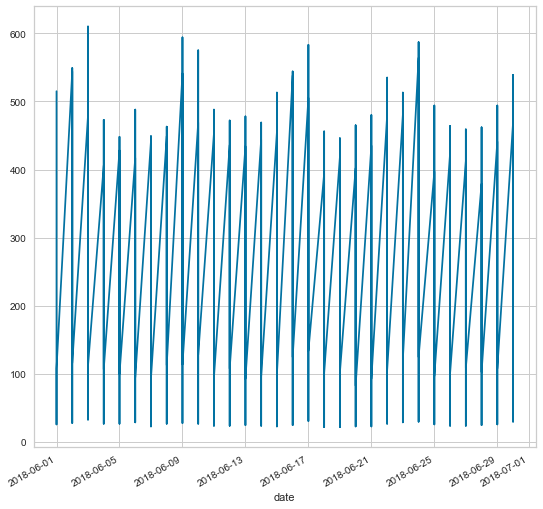

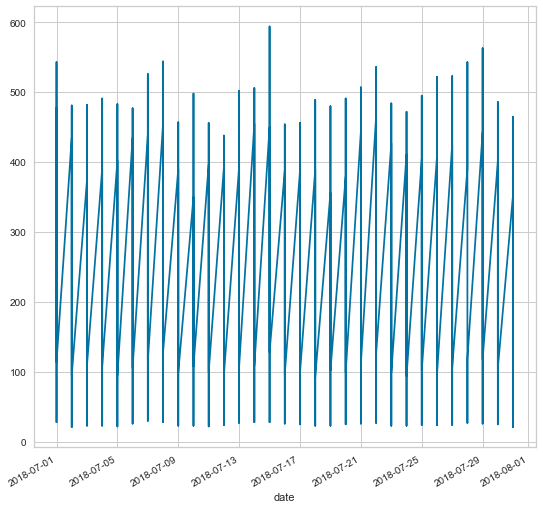

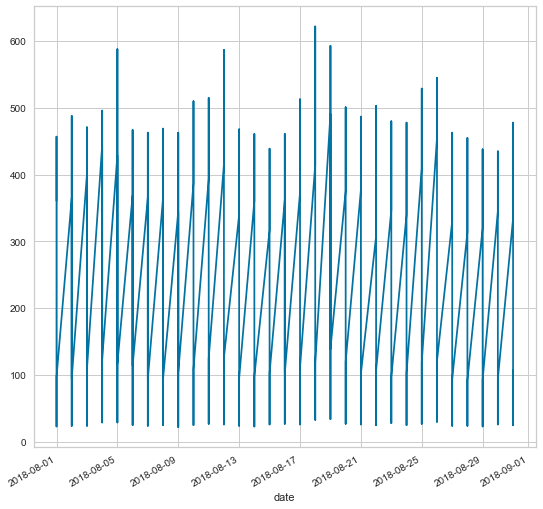

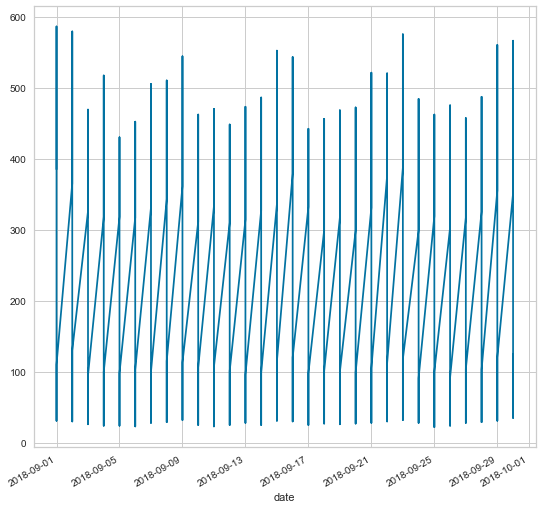

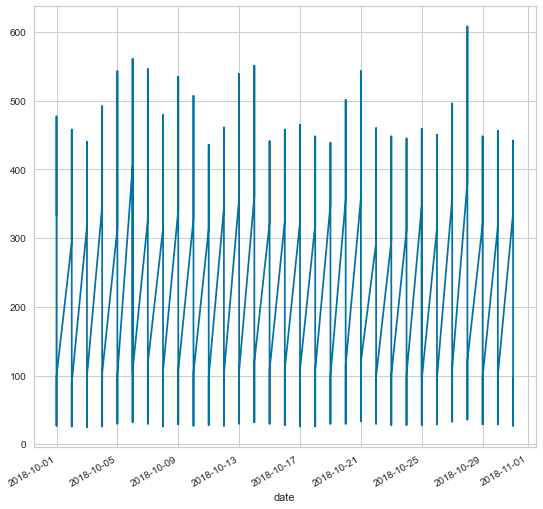

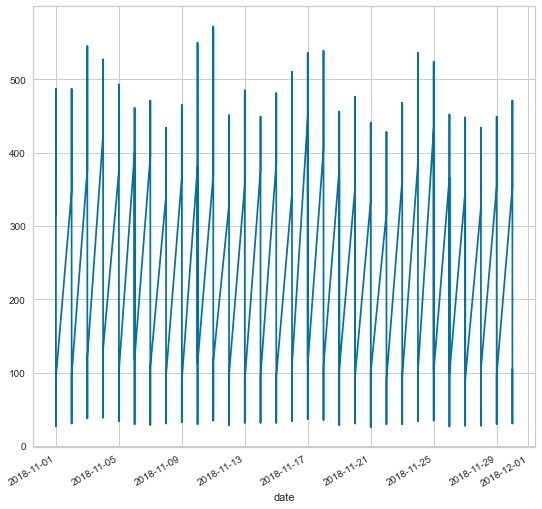

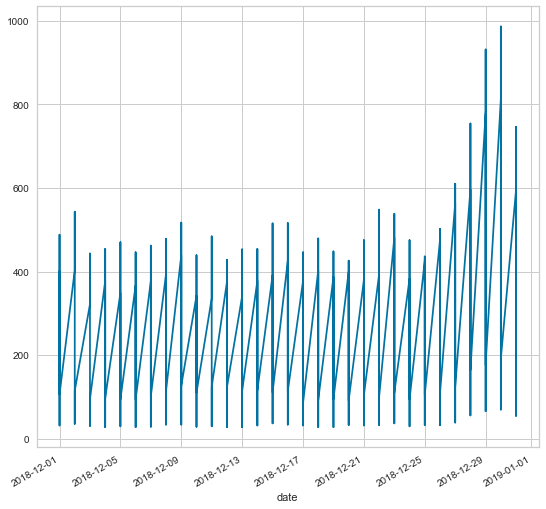

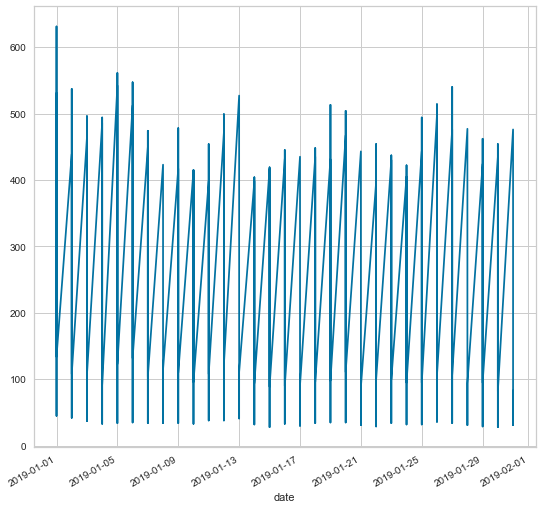

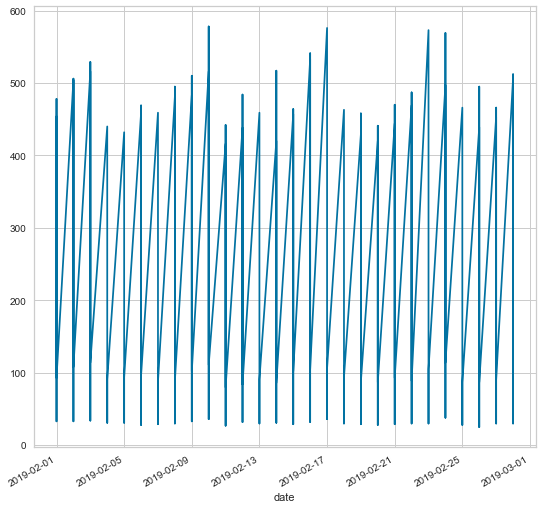

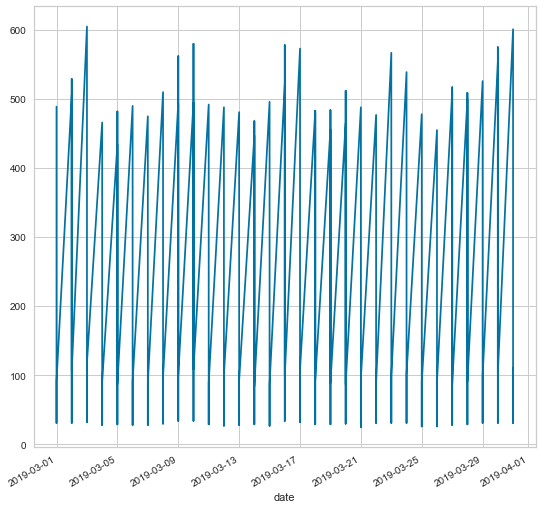

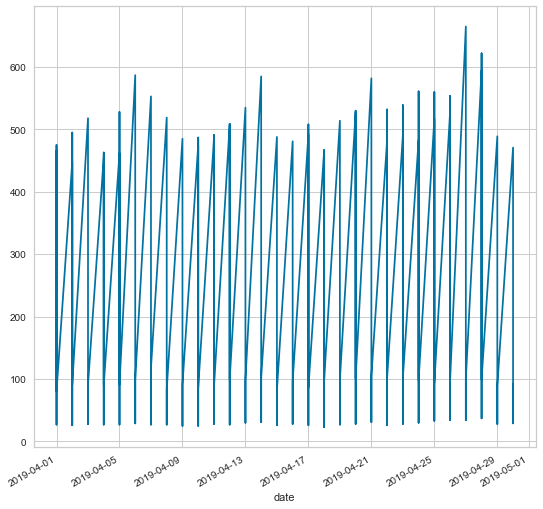

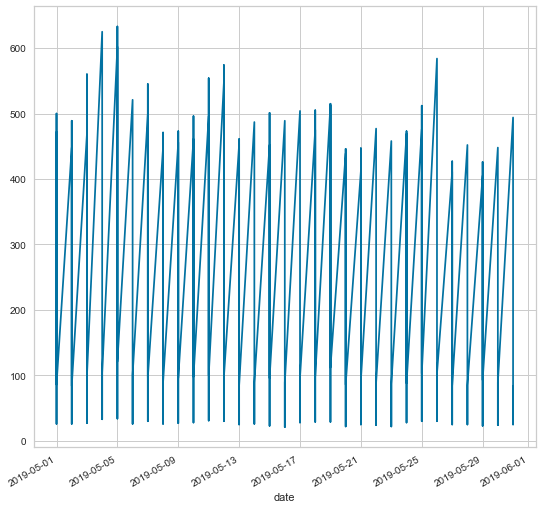

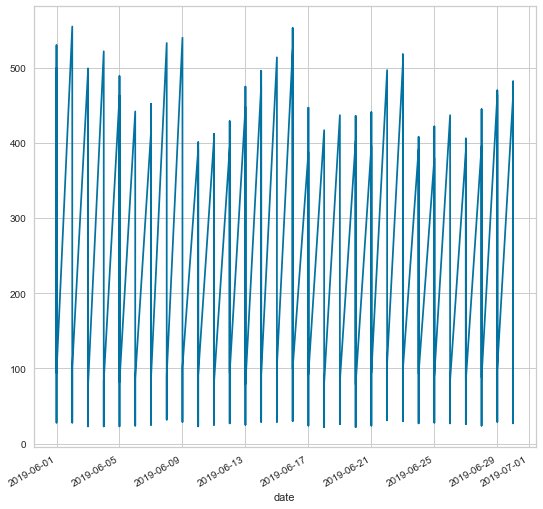

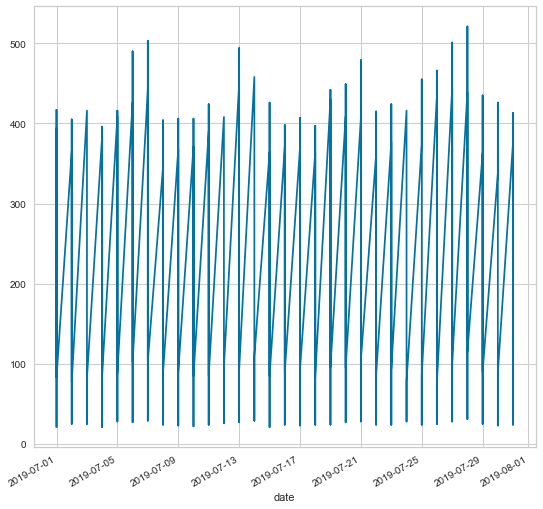

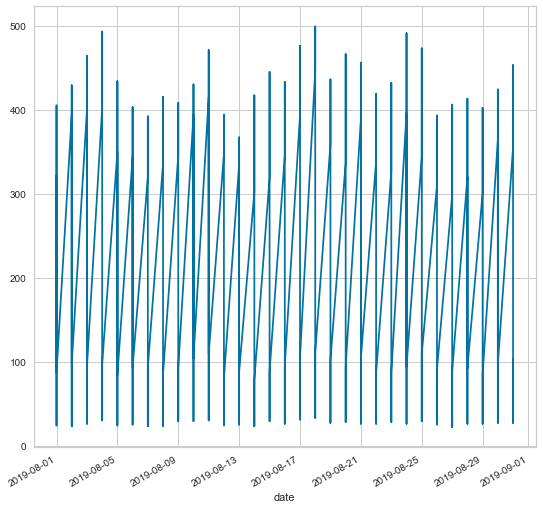

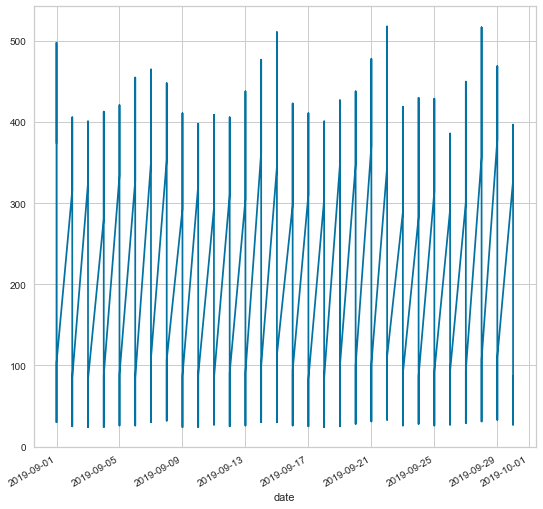

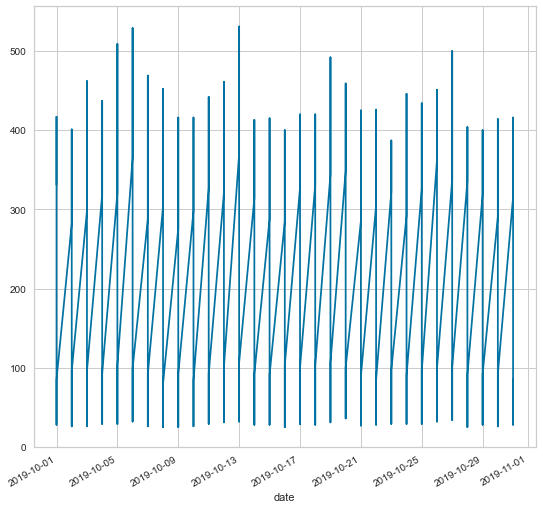

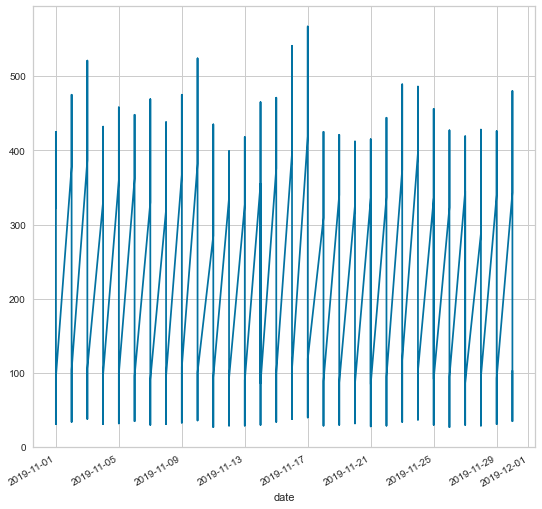

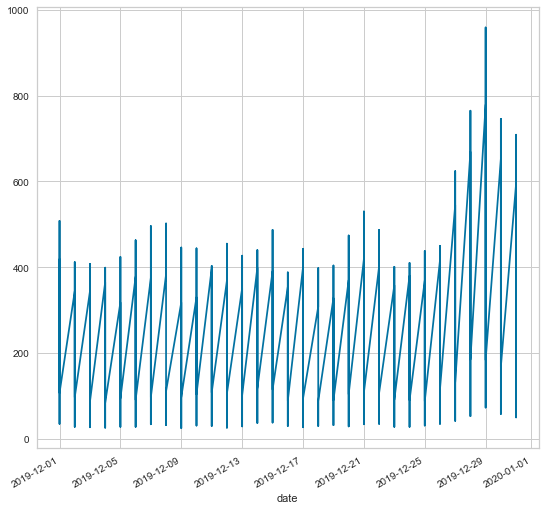

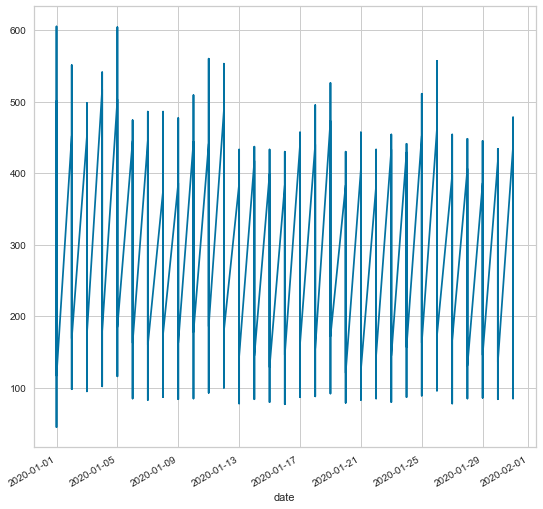

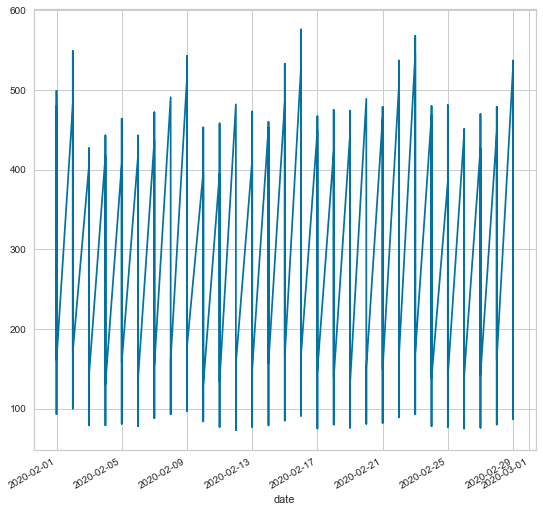

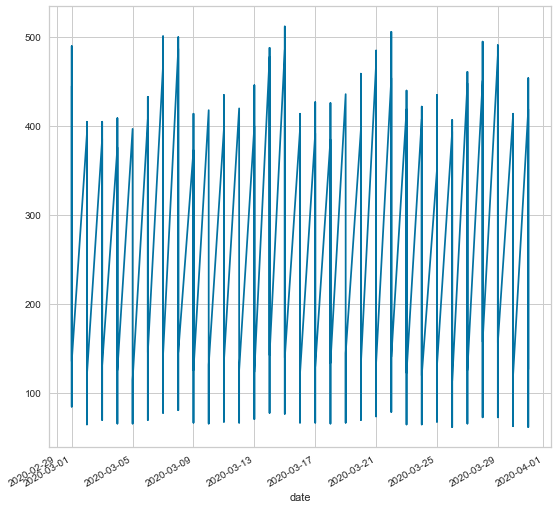

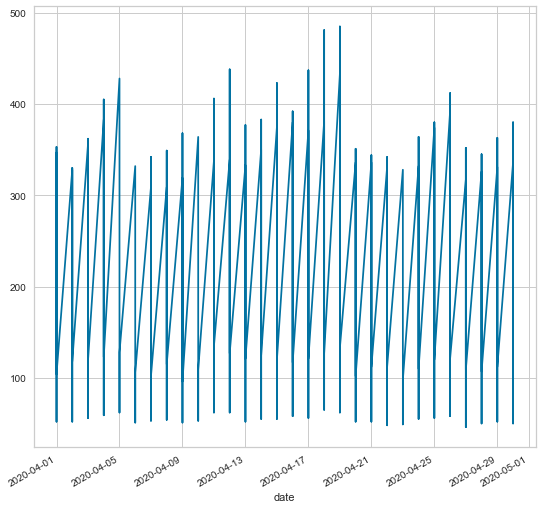

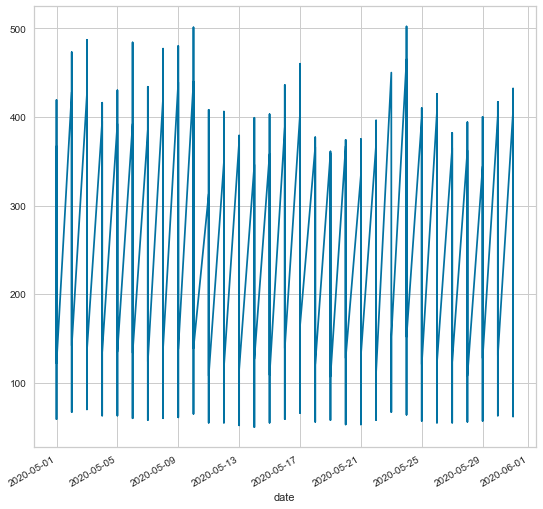

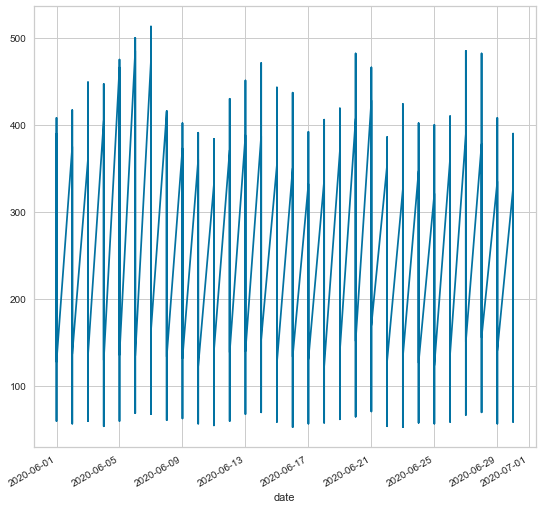

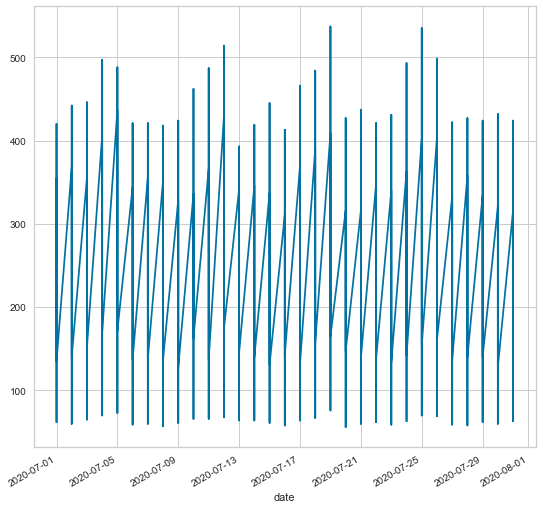

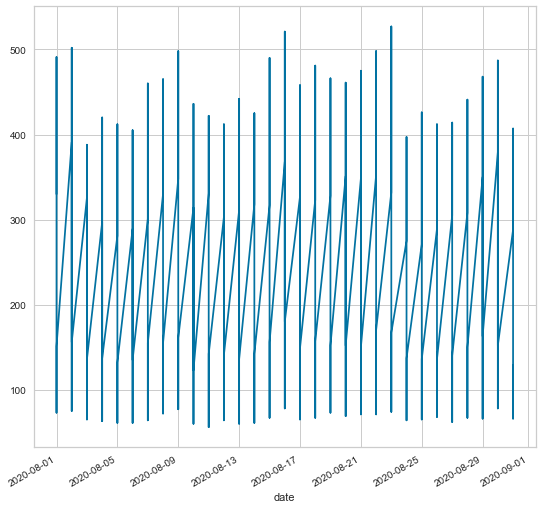

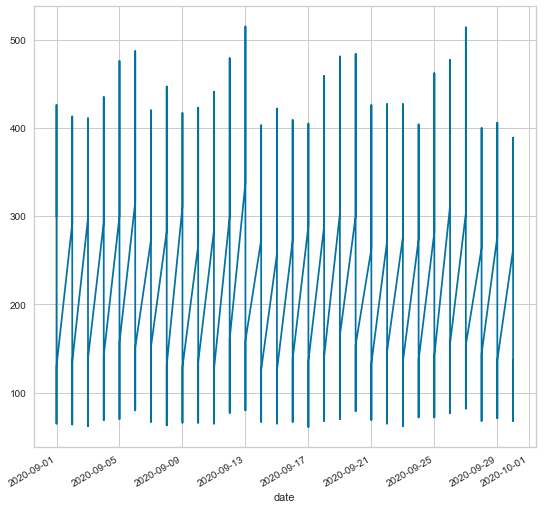

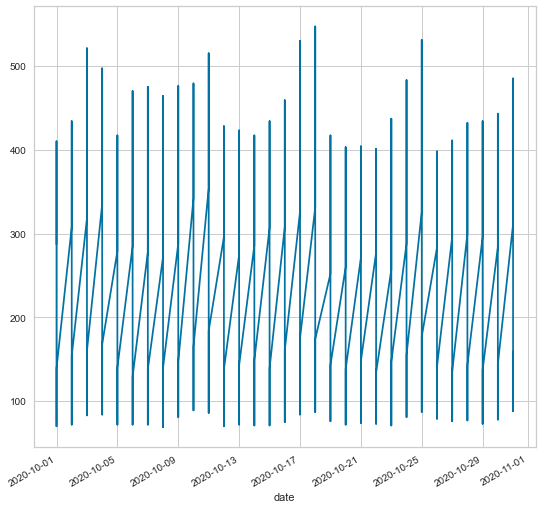

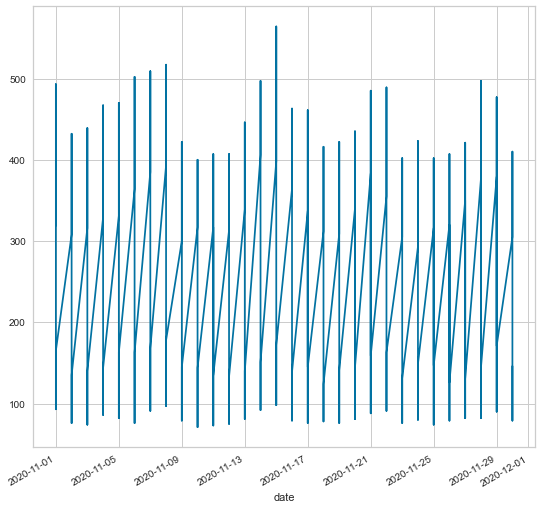

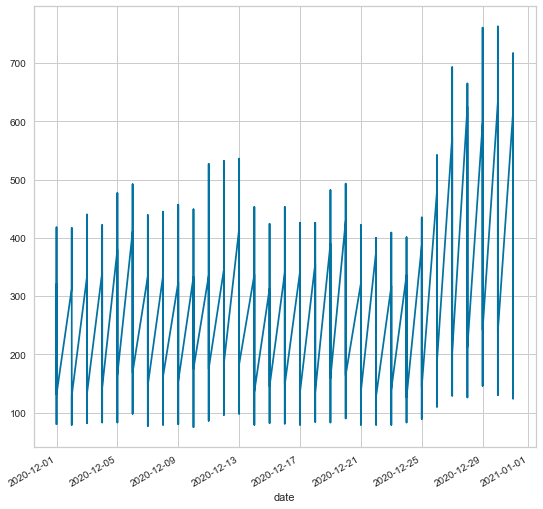

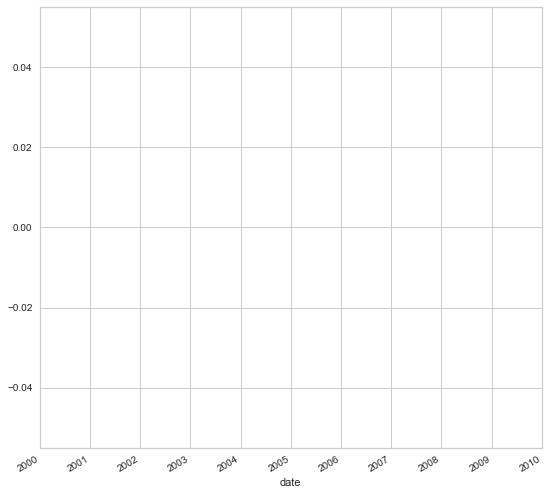

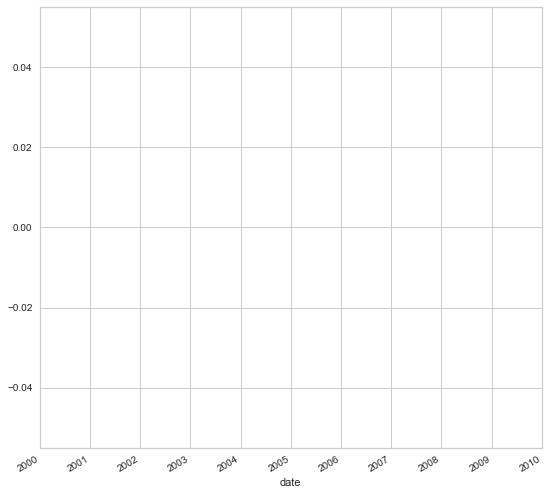

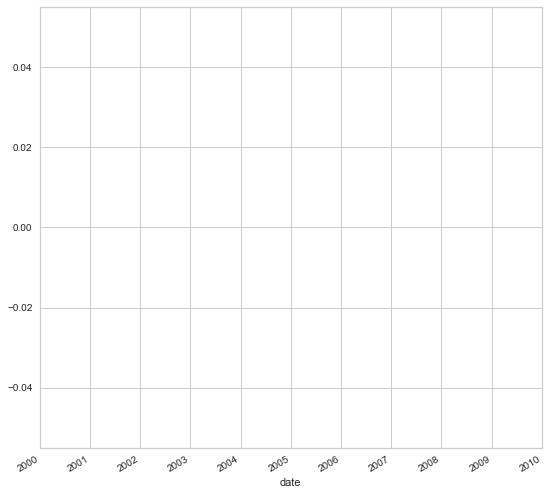

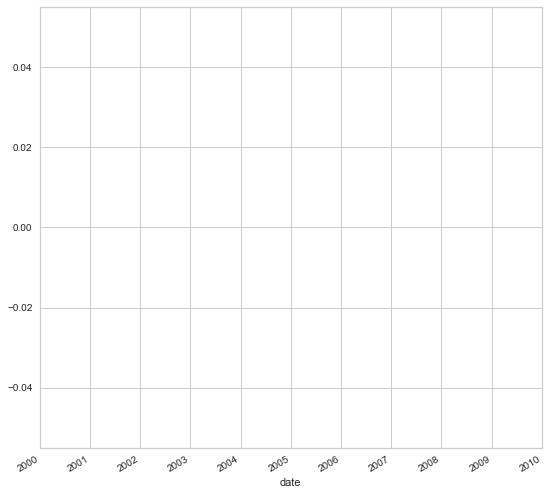

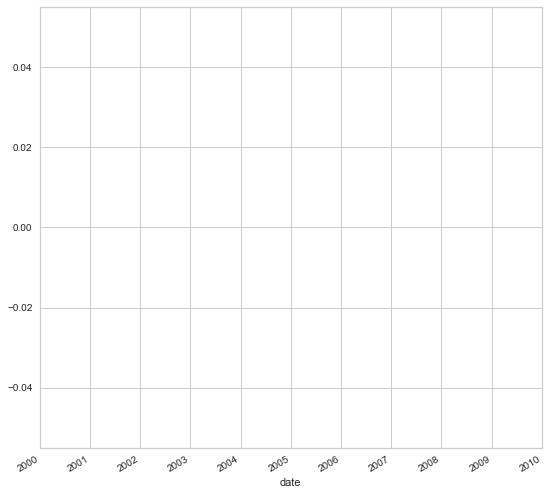

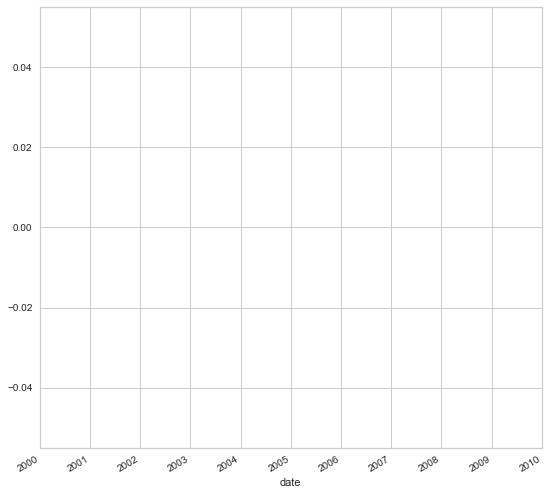

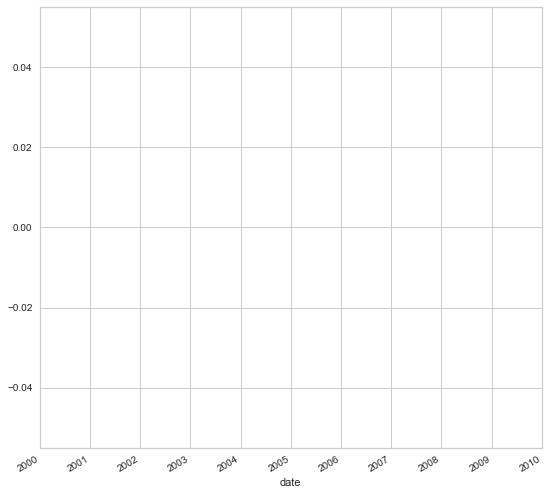

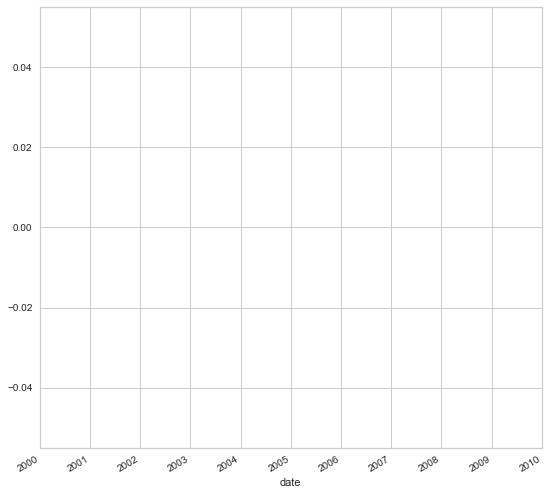

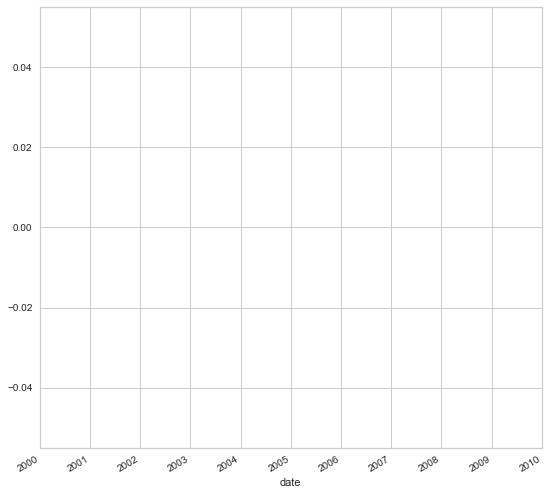

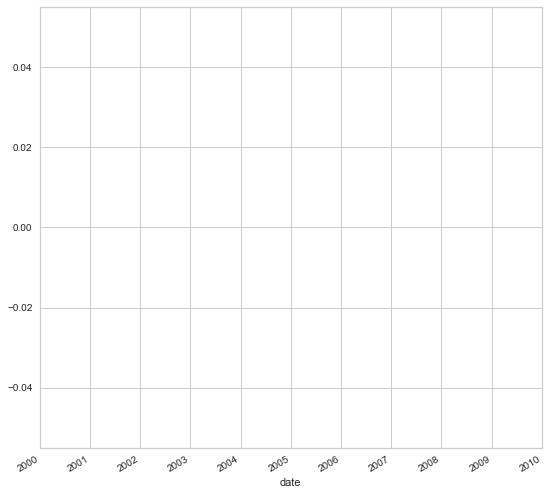

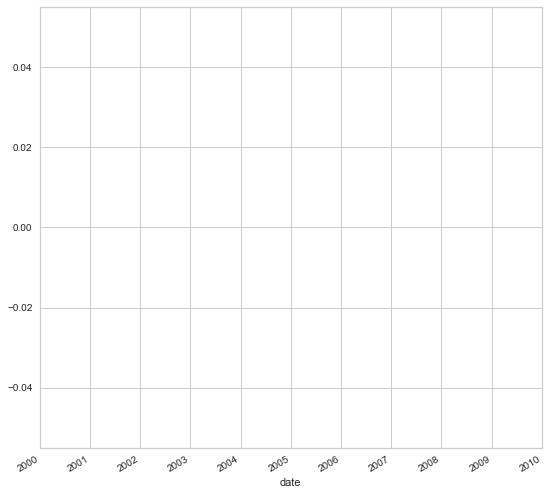

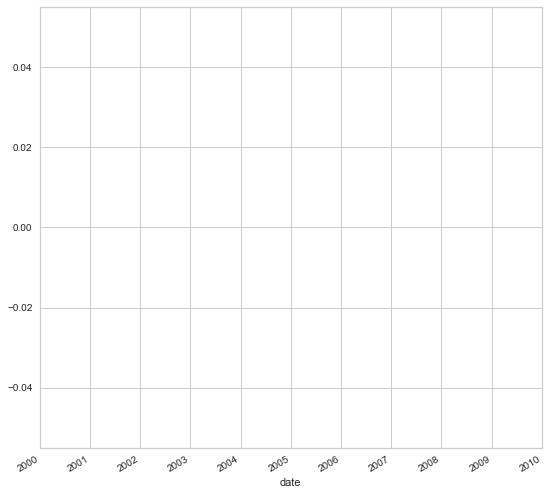

In [445]:
# tüm yıl ve ayların toplam satış grafiklerini çıkaralım
for year in train.year.unique():
    for month in train.month.unique():
        new_train.loc[(new_train.year==year) & (new_train.month==month),"num_sold"].plot(figsize=(9,9))
        plt.show(block=True)

In [446]:
train.groupby("year").agg({"num_sold":["sum","mean"]})

num_sold            
            sum        mean
year                       
2017  3112163.0  177.634874
2018  3425424.0  195.515068
2019  3232879.0  184.525057
2020  3855193.0  219.444046
2021        0.0         NaN

In [447]:
train.groupby(["country","store","product","month"]).agg({"num_sold":["sum","mean"]})

num_sold            
                                                               sum        mean
country store      product                          month                     
Belgium KaggleMart Kaggle Advanced Techniques       1      55089.0  444.266129
                                                    2      52555.0  465.088496
                                                    3      58732.0  473.645161
                                                    4      56189.0  468.241667
                                                    5      57297.0  462.072581
...                                                            ...         ...
Spain   KaggleRama Kaggle for Kids: One Smart Goose 8      13652.0  110.096774
                                                    9      12974.0  108.116667
                                                    10     13679.0  110.314516
                                                    11     13300.0  110.833333
                                                    12     15341.0  123.717742

[576 rows x 2 columns]

In [448]:
# hedef değişken ile bağımsız değişkenler arasındaki ilişkiyi inceleyelim
def target_sum_wcat(dataframe,target,cat_col):
    print(cat_col.upper())
    print(pd.DataFrame(dataframe.groupby(cat_col).agg({target:["mean","sum","median"]})))
    print("\n")

In [449]:
for cat_col in cat_cols:
    target_sum_wcat(train,"num_sold",cat_col)

COUNTRY
           num_sold                  
               mean        sum median
country                              
Belgium  237.940623  2781050.0  194.0
France   214.948580  2512319.0  176.0
Germany  238.399641  2786415.0  194.0
Italy    188.320671  2201092.0  155.0
Poland   114.779689  1341545.0   90.0
Spain    171.392710  2003238.0  143.0


STORE
              num_sold                   
                  mean         sum median
store                                    
KaggleMart  288.536790  10117254.0  283.0
KaggleRama  100.057181   3508405.0   98.0


PRODUCT
                                    num_sold                  
                                        mean        sum median
product                                                       
Kaggle Advanced Techniques        223.243783  3913910.0  162.0
Kaggle Getting Started            178.924424  3136903.0  126.0
Kaggle Recipe Book                134.030173  2349817.0   93.0
Kaggle for Kids: One Smart Goose  240.989562

In [450]:
# Feature Engineering

In [451]:
from datetime import date 
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,LabelEncoder

<AxesSubplot:xlabel='num_sold'>

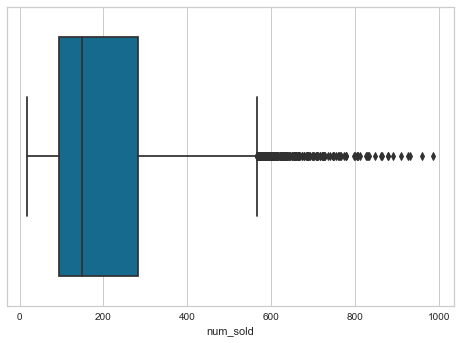

In [452]:
# Outliers
# Num_Sold outliers with graph
sns.boxplot(x=train["num_sold"],)

In [453]:
train["num_sold"].mean()

194.29698551220625

In [454]:
# Aykırı değer eşik değerlerini belirleyelim
def outlier_thresholds(dataframe,col_name,q1=0.05,q3=0.95):
    quartile1=dataframe[col_name].quantile(q1)
    quartile3=dataframe[col_name].quantile(q3)
    interquartile=quartile3-quartile1
    low_limit=quartile1-1.5*interquartile
    up_limit=quartile3+1.5*interquartile
    return low_limit,up_limit

In [455]:
def check_outlier(dataframe,col_name,q1=0.25,q3=0.75):
    low_limit,up_limit=outlier_thresholds(dataframe,col_name,q1=q1,q3=q3)
    print(col_name.upper())
    if dataframe.loc[(dataframe[col_name]>up_limit) | (dataframe[col_name]<low_limit),:].any(axis=None):
        dataframe.loc[(dataframe[col_name]>up_limit)| (dataframe[col_name]<low_limit)].index
        return True
    else:
        return False

In [456]:
low_limit,up_limit=outlier_thresholds(train,"num_sold",q1=0.25,q3=0.75)

In [457]:
train.num_sold.max()

986.0

In [458]:
train.num_sold.min()

19.0

In [459]:
check_outlier(train,"num_sold",q1=0.25,q3=0.75)

NUM_SOLD


True

In [460]:
# aykırı değerlerin indexlerini çekelim ve gözlem birimlerine erişelim
def grab_outliers(dataframe,col_name,index=False,q1=0.25,q3=0.75):
    low,up=outlier_thresholds(dataframe,col_name,q1=q1,q3=q3)
    
    if dataframe[((dataframe[col_name]<low) | (dataframe[col_name]>up))].shape[0]>10:
        print(dataframe[((dataframe[col_name]<low) | (dataframe[col_name]>up))].head())
    else:
        print(dataframe[((dataframe[col_name]<low)| (dataframe[col_name]>up))])
    if index:
        outlier_index=dataframe[((dataframe[col_name]<low)|(dataframe[col_name]>up))].index
    return outlier_index

In [461]:
outlier_index=grab_outliers(train,"num_sold",index=True,q1=0.25,q3=0.75)

    row_id       date  country       store                           product  \
0        0 2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1        1 2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
3        3 2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
8        8 2017-01-01   France  KaggleMart        Kaggle Advanced Techniques   
11      11 2017-01-01   France  KaggleMart  Kaggle for Kids: One Smart Goose   

    num_sold  year  month  day_of_year  day_of_week  week_of_year  \
0      663.0  2017      1            1            6            52   
1      615.0  2017      1            1            6            52   
3      710.0  2017      1            1            6            52   
8      610.0  2017      1            1            6            52   
11     672.0  2017      1            1            6            52   

    is_month_start  is_wknd  is_month_end  day  
0                1        6             0    1  
1     

In [462]:
train.loc[outlier_index,"num_sold"].mean()

638.7287066246057

In [463]:
# aykırı değerleri çözelim
# silme metodu uygulayalım
def remove_outlier(dataframe,col_name,q1=0.25,q3=0.75):
    low_limit,up_limit=outlier_thresholds(dataframe,col_name,q1=q1,q3=q3)
    df_without_outliers=dataframe[~((dataframe[col_name]<low_limit)|(dataframe[col_name]>up_limit))]
    return df_without_outliers
# baskılama yöntemini uygulayalım
def replace_with_thresholds(dataframe,col_name,q1=0.25,q3=0.75):
    low_limit,up_limit=outlier_thresholds(dataframe,col_name,q1=q1,q3=q3)
    dataframe.loc[(dataframe[col_name]<low_limit),col_name]=low_limit
    dataframe.loc[(dataframe[col_name]>up_limit),col_name]=up_limit

In [464]:
#iki farklı yöntemi karşılaştırmak amacıyla train verisinin kopyasını alalım
new_train=train.copy()

In [465]:
# aykırı değerler varken num_sold ortalaması
new_train.num_sold.mean()

194.29698551220625

In [466]:
replace_with_thresholds(new_train,"num_sold")

In [467]:
new_train.num_sold.mean()

193.963709217431

In [468]:
#iki farklı yöntemi karşılaştırmak amacıyla train verisinin kopyasını alalım
new_train=train.copy()

In [469]:
new_train=remove_outlier(new_train,"num_sold")

In [470]:
new_train.num_sold.mean()

192.27889587600808

In [471]:
# train verisindeki aykırı değerleri silerek aykırı değer problemini çözelim
train=remove_outlier(train,"num_sold")

In [472]:
train.head()

,row_id,date,country,store,product,num_sold,year,month,day_of_year,day_of_week,week_of_year,is_month_start,is_wknd,is_month_end,day
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480.0,2017,1,1,6,52,1,6,0,1
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240.0,2017,1,1,6,52,1,6,0,1
5,5,2017-01-01,Belgium,KaggleRama,Kaggle Getting Started,187.0,2017,1,1,6,52,1,6,0,1
6,6,2017-01-01,Belgium,KaggleRama,Kaggle Recipe Book,158.0,2017,1,1,6,52,1,6,0,1
7,7,2017-01-01,Belgium,KaggleRama,Kaggle for Kids: One Smart Goose,267.0,2017,1,1,6,52,1,6,0,1


In [473]:
cat_cols

['country', 'store', 'product', 'year', 'day_of_week', 'is_wknd']

In [474]:
# Enoding 
# One Hot Encoding
#train=pd.get_dummies(train,columns=['country', 'store', 'product'],drop_first=True)

In [475]:
train.head()

,row_id,date,country,store,product,num_sold,year,month,day_of_year,day_of_week,week_of_year,is_month_start,is_wknd,is_month_end,day
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480.0,2017,1,1,6,52,1,6,0,1
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240.0,2017,1,1,6,52,1,6,0,1
5,5,2017-01-01,Belgium,KaggleRama,Kaggle Getting Started,187.0,2017,1,1,6,52,1,6,0,1
6,6,2017-01-01,Belgium,KaggleRama,Kaggle Recipe Book,158.0,2017,1,1,6,52,1,6,0,1
7,7,2017-01-01,Belgium,KaggleRama,Kaggle for Kids: One Smart Goose,267.0,2017,1,1,6,52,1,6,0,1


In [476]:
# ayırdığımız zaman değişkenlerini silelim
# train.drop(["year","day_of_year","day_of_week","day","month"],axis=1,inplace=True)

In [477]:
# Time Series Analysis

In [478]:
import itertools
import warnings 
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
warnings.filterwarnings("ignore")

In [479]:
# Forecasting with ML
import lightgbm as lgb

In [480]:
train.groupby(["country","store","product"]).agg({"num_sold":["sum","mean","median","std"]})

num_sold              \
                                                          sum        mean   
country store      product                                                  
Belgium KaggleMart Kaggle Advanced Techniques        558113.0  397.233452   
                   Kaggle Getting Started            470852.0  324.055058   
                   Kaggle Recipe Book                355212.0  243.462646   
                   Kaggle for Kids: One Smart Goose  610096.0  430.858757   
        KaggleRama Kaggle Advanced Techniques        205826.0  140.880219   
                   Kaggle Getting Started            165153.0  113.041068   
                   Kaggle Recipe Book                123803.0   84.738535   
                   Kaggle for Kids: One Smart Goose  222190.0  152.080767   
France  KaggleMart Kaggle Advanced Techniques        524803.0  363.688843   
                   Kaggle Getting Started            427882.0  293.471879   
                   Kaggle Recipe Book                321652.0  220.158795   
                   Kaggle for Kids: One Smart Goose  565324.0  392.041609   
        KaggleRama Kaggle Advanced Techniques        186116.0  127.389459   
                   Kaggle Getting Started            148831.0  101.869268   
                   Kaggle Recipe Book                111312.0   76.188912   
                   Kaggle for Kids: One Smart Goose  200543.0  137.264203   
Germany KaggleMart Kaggle Advanced Techniques        556812.0  397.155492   
                   Kaggle Getting Started            470585.0  323.871301   
                   Kaggle Recipe Book                356119.0  244.084304   
                   Kaggle for Kids: One Smart Goose  607598.0  430.920567   
        KaggleRama Kaggle Advanced Techniques        206650.0  141.444216   
                   Kaggle Getting Started            165485.0  113.268309   
                   Kaggle Recipe Book                123788.0   84.728268   
                   Kaggle for Kids: One Smart Goose  222165.0  152.063655   
Italy   KaggleMart Kaggle Advanced Techniques        463365.0  319.562069   
                   Kaggle Getting Started            376232.0  257.516769   
                   Kaggle Recipe Book                281614.0  192.754278   
                   Kaggle for Kids: One Smart Goose  497721.0  343.967519   
        KaggleRama Kaggle Advanced Techniques        162675.0  111.344969   
                   Kaggle Getting Started            130409.0   89.260096   
                   Kaggle Recipe Book                 97607.0   66.808350   
                   Kaggle for Kids: One Smart Goose  175357.0  120.025325   
Poland  KaggleMart Kaggle Advanced Techniques        282429.0  193.975962   
                   Kaggle Getting Started            228831.0  156.626283   
                   Kaggle Recipe Book                171379.0  117.302533   
                   Kaggle for Kids: One Smart Goose  307271.0  211.037775   
        KaggleRama Kaggle Advanced Techniques         98726.0   67.574264   
                   Kaggle Getting Started             79342.0   54.306639   
                   Kaggle Recipe Book                 59258.0   40.559890   
                   Kaggle for Kids: One Smart Goose  107622.0   73.663244   
Spain   KaggleMart Kaggle Advanced Techniques        423441.0  291.024742   
                   Kaggle Getting Started            342798.0  234.632444   
                   Kaggle Recipe Book                257082.0  175.963039   
                   Kaggle for Kids: One Smart Goose  457566.0  314.262363   
        KaggleRama Kaggle Advanced Techniques        148048.0  101.333333   
                   Kaggle Getting Started            118532.0   81.130732   
                   Kaggle Recipe Book                 88687.0   60.702943   
                   Kaggle for Kids: One Smart Goose  160280.0  109.705681   

                                                                        
                                                    

In [481]:
train.groupby(["country"])["store"].nunique()

country
Belgium    2
France     2
Germany    2
Italy      2
Poland     2
Spain      2
Name: store, dtype: int64

In [482]:
train.groupby(["country","store"])["product"].nunique()

country  store     
Belgium  KaggleMart    4
         KaggleRama    4
France   KaggleMart    4
         KaggleRama    4
Germany  KaggleMart    4
         KaggleRama    4
Italy    KaggleMart    4
         KaggleRama    4
Poland   KaggleMart    4
         KaggleRama    4
Spain    KaggleMart    4
         KaggleRama    4
Name: product, dtype: int64

In [483]:
train.head(10)

,row_id,date,country,store,product,num_sold,year,month,day_of_year,day_of_week,week_of_year,is_month_start,is_wknd,is_month_end,day
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480.0,2017,1,1,6,52,1,6,0,1
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240.0,2017,1,1,6,52,1,6,0,1
5,5,2017-01-01,Belgium,KaggleRama,Kaggle Getting Started,187.0,2017,1,1,6,52,1,6,0,1
6,6,2017-01-01,Belgium,KaggleRama,Kaggle Recipe Book,158.0,2017,1,1,6,52,1,6,0,1
7,7,2017-01-01,Belgium,KaggleRama,Kaggle for Kids: One Smart Goose,267.0,2017,1,1,6,52,1,6,0,1
9,9,2017-01-01,France,KaggleMart,Kaggle Getting Started,463.0,2017,1,1,6,52,1,6,0,1
10,10,2017-01-01,France,KaggleMart,Kaggle Recipe Book,407.0,2017,1,1,6,52,1,6,0,1
12,12,2017-01-01,France,KaggleRama,Kaggle Advanced Techniques,220.0,2017,1,1,6,52,1,6,0,1
13,13,2017-01-01,France,KaggleRama,Kaggle Getting Started,172.0,2017,1,1,6,52,1,6,0,1
14,14,2017-01-01,France,KaggleRama,Kaggle Recipe Book,140.0,2017,1,1,6,52,1,6,0,1


In [484]:
# groupby içine ay da dahil edilip satış sayılarını inceleyelim
train.groupby(["country","store","product","month"]).agg({"num_sold":["sum","mean","median","std"]})

num_sold  \
                                                               sum   
country store      product                          month            
Belgium KaggleMart Kaggle Advanced Techniques       1      53860.0   
                                                    2      50257.0   
                                                    3      53980.0   
                                                    4      46527.0   
                                                    5      51882.0   
...                                                            ...   
Spain   KaggleRama Kaggle for Kids: One Smart Goose 8      13652.0   
                                                    9      12974.0   
                                                    10     13679.0   
                                                    11     13300.0   
                                                    12     15341.0   

                                                                              \
                                                                 mean median   
country store      product                          month                      
Belgium KaggleMart Kaggle Advanced Techniques       1      441.475410  435.0   
                                                    2      461.073394  457.0   
                                                    3      465.344828  471.0   
                                                    4      447.375000  466.5   
                                                    5      451.147826  452.0   
...                                                               ...    ...   
Spain   KaggleRama Kaggle for Kids: One Smart Goose 8      110.096774  102.0   
                                                    9      108.116667  100.0   
                                                    10     110.314516  101.0   
                                                    11     110.833333  101.0   
                                                    12     123.717742  110.5   

                                                                      
                                                                 std  
country store      product                          month             
Belgium KaggleMart Kaggle Advanced Techniques       1      45.700645  
                                                    2      39.256211  
                                                    3      45.369038  
                                                    4      70.807024  
                                                    5      56.587495  
...                                                              ...  
Spain   KaggleRama Kaggle for Kids: One Smart Goose 8      24.973618  
                                                    9      22.491897  
                                                    10     25.377913  
                                                    11     24.226291  
                                                    12     35.027413  

[576 rows x 4 columns]

In [485]:
# Random noise for block overfitting
def random_noise(dataframe):
    return np.random.normal(scale=1.5,size=(len(dataframe)))

In [486]:
train.head()

,row_id,date,country,store,product,num_sold,year,month,day_of_year,day_of_week,week_of_year,is_month_start,is_wknd,is_month_end,day
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480.0,2017,1,1,6,52,1,6,0,1
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240.0,2017,1,1,6,52,1,6,0,1
5,5,2017-01-01,Belgium,KaggleRama,Kaggle Getting Started,187.0,2017,1,1,6,52,1,6,0,1
6,6,2017-01-01,Belgium,KaggleRama,Kaggle Recipe Book,158.0,2017,1,1,6,52,1,6,0,1
7,7,2017-01-01,Belgium,KaggleRama,Kaggle for Kids: One Smart Goose,267.0,2017,1,1,6,52,1,6,0,1


In [487]:
# Lag/Shifted Features 
def lag_features(dataframe,lags):
    for lag in lags:
        dataframe["sales_lag"+str(lag)]=dataframe.groupby(["country","store","product"])["num_sold"].transform(lambda x:x.shift(lag))+random_noise(dataframe)
    return dataframe
train=lag_features(train,[91,98,105,112,119,126,182,364,546,728])

In [488]:
check_df(train)

Observations:87331
Variables:25
NaN Values
row_id                0
date                  0
country               0
store                 0
product               0
num_sold          17520
year                  0
month                 0
day_of_year           0
day_of_week           0
week_of_year          0
is_month_start        0
is_wknd               0
is_month_end          0
day                   0
sales_lag91       17520
sales_lag98       17520
sales_lag105      17520
sales_lag112      17520
sales_lag119      17520
sales_lag126      17520
sales_lag182      17520
sales_lag364      17520
sales_lag546      26208
sales_lag728      34944
dtype: int64
Types
row_id                     int64
date              datetime64[ns]
country                   object
store                     object
product                   object
num_sold                 float64
year                       int64
month                      int64
day_of_year                int64
day_of_week                int64
week_of_

In [489]:
# Rolling Mean Features
def roll_mean_features(dataframe,windows):
    for window in windows:
        dataframe["sales_roll_mean_"+str(window)]=dataframe.groupby(["country","store","product"])["num_sold"].transform(lambda x:x.shift(1).rolling(window=window,min_periods=10,win_type="triang").mean())+random_noise(dataframe)
        return dataframe
train=roll_mean_features(train,[365,546])

In [490]:
# Exponentially Weighted Mean Features
def ewm_features(dataframe,alphas,lags):
    for alpha in alphas:
        for lag in lags:
            dataframe["sales_ewm_alpha"+str(alpha).replace(".","")+"_lag_"+str(lag)]=dataframe.groupby(["country"
                                                                                                       ,"store",
                                                                                                      "product"])["num_sold"].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91,98,105,112,119,126,182,364,546,728]

In [491]:
train=ewm_features(train,alphas,lags)

In [492]:
train.head()

,row_id,date,country,store,product,num_sold,year,month,day_of_year,day_of_week,...,sales_ewm_alpha05_lag_91,sales_ewm_alpha05_lag_98,sales_ewm_alpha05_lag_105,sales_ewm_alpha05_lag_112,sales_ewm_alpha05_lag_119,sales_ewm_alpha05_lag_126,sales_ewm_alpha05_lag_182,sales_ewm_alpha05_lag_364,sales_ewm_alpha05_lag_546,sales_ewm_alpha05_lag_728
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480.0,2017,1,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240.0,2017,1,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2017-01-01,Belgium,KaggleRama,Kaggle Getting Started,187.0,2017,1,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,2017-01-01,Belgium,KaggleRama,Kaggle Recipe Book,158.0,2017,1,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,2017-01-01,Belgium,KaggleRama,Kaggle for Kids: One Smart Goose,267.0,2017,1,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [493]:
# One-Hot Encoding
train= pd.get_dummies(train, columns=['country','store', 'product',"month","day_of_week"])

In [494]:
# Converting sales to log(1+sales) # train süresini kısaltmak amacıyla
train['num_sold'] = np.log1p(train["num_sold"].values)

In [495]:
# Custom Cost Function
########################

# MAE, MSE, RMSE, SSE

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [496]:
train.head()

,row_id,date,num_sold,year,day_of_year,week_of_year,is_month_start,is_wknd,is_month_end,day,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
2,2,2017-01-01,6.175867,2017,1,52,1,6,0,1,...,0,0,0,0,0,0,0,0,0,1
4,4,2017-01-01,5.484797,2017,1,52,1,6,0,1,...,0,0,0,0,0,0,0,0,0,1
5,5,2017-01-01,5.236442,2017,1,52,1,6,0,1,...,0,0,0,0,0,0,0,0,0,1
6,6,2017-01-01,5.068904,2017,1,52,1,6,0,1,...,0,0,0,0,0,0,0,0,0,1
7,7,2017-01-01,5.590987,2017,1,52,1,6,0,1,...,0,0,0,0,0,0,0,0,0,1


In [497]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [498]:
# Time-Based Validation Sets


train
test

# 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
new_train = train.loc[(train["date"] < "2020-01-01"), :]

# 2017'nin ilk 3'ayı validasyon seti.
val = train.loc[(train["date"] >= "2020-01-01") & (train["date"] < "2021-01-01"), :]

cols = [col for col in new_train.columns if col not in ['date','row_id', "num_sold","year"	,"day_of_year"	,"week_of_year",	"is_month_start",	"is_wknd"	,"is_month_end",	"day"]]

Y_train = new_train['num_sold']
X_train = new_train[cols]

Y_val = val['num_sold']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((52304,), (52304, 92), (17507,), (17507, 92))

In [531]:
# LightGBM ile Zaman Serisi Modeli

# !pip install lightgbm
# conda install lightgbm


# LightGBM parameters
lgb_params = {'num_leaves': 2,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 10,
              'verbose': 0,
              'num_boost_round': 20000,
              'early_stopping_rounds': 200,
              'nthread': -1}

# metric mae: l1, absolute loss, mean_absolute_error, regression_l1
# mse: l2, square loss, mean_squared_error, mse, regression_l2, regression
# rmse, root square loss, root_mean_squared_error, l2_root
# mape, MAPE loss, mean_absolute_percentage_error

# num_leaves: bir ağaçtaki maksimum yaprak sayısı
# learning_rate: shrinkage_rate, eta
# feature_fraction: rf'nin random subspace özelliği. her iterasyonda rastgele göz önünde bulundurulacak değişken sayısı.
# max_depth: maksimum derinlik
# num_boost_round: n_estimators, number of boosting iterations. En az 10000-15000 civarı yapmak lazım.

# early_stopping_rounds: validasyon setindeki metrik belirli bir early_stopping_rounds'da ilerlemiyorsa yani
# hata düşmüyorsa modellemeyi durdur.
# hem train süresini kısaltır hem de overfit'e engel olur.
# nthread: num_thread, nthread, nthreads, n_jobs

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014298 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.091208	training's SMAPE: 22.5424	valid_1's l2: 0.107011	valid_1's SMAPE: 25.201
[200]	training's l2: 0.0464722	training's SMAPE: 16.5867	valid_1's l2: 0.089869	valid_1's SMAPE: 21.869
[300]	training's l2: 0.0366569	training's SMAPE: 14.7488	valid_1's l2: 0.0918207	valid_1's SMAPE: 21.4523
[400]	training's l2: 0.0329766	training's SMAPE: 13.9669	valid_1's l2: 0.0933633	valid_1's SMAPE: 21.3635
Early stopping, best iteration is:
[215]	training's l2: 0.0440764	training's SMAPE: 16.179	valid_1's l2: 0.0898149	valid_1's SMAPE: 21.7157


21.715699141816945

In [532]:
test=train.loc[train.date>="2021-01-01"]

In [533]:
test.drop(["num_sold"],axis=1,inplace=True)

In [534]:
test.drop(["date","row_id"],axis=1,inplace=True)

In [535]:
for i in test.columns:
    if i not in X_train.columns:
        print(i)

year
day_of_year
week_of_year
is_month_start
is_wknd
is_month_end
day


In [536]:
test.drop(["year" ,"day_of_year",
"week_of_year",
"is_month_start",
"is_wknd",
"is_month_end",
"day"],axis=1,inplace=True)

In [537]:
test.shape

(17520, 92)

In [538]:
y_forecast=model.predict(test, num_iteration=model.best_iteration)

In [539]:
y_forecast_np=np.expm1(y_forecast)

In [540]:
test_result=train.loc[train.date>="2021-01-01"]

In [541]:
test_result.loc[:,"num_sold"]=y_forecast_np

In [542]:
submission=test_result[["row_id","num_sold"]]

In [543]:
submission.head()

,row_id,num_sold
0,70128,327.509982
1,70129,299.607630
2,70130,224.867375
3,70131,350.051007
4,70132,116.403191


In [544]:
submission.to_csv("third_sub.csv",index=False)

In [ ]:
#end

In [513]:
# Clustering gerçekleştirip daha sonra modelimizi eğitelim